<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/03_MAB_movielens_ucb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Armed Bandits - Upper Confidence Bounds

Rather than performing exploration by simply selecting an arbitrary action, chosen with a probability that remains constant, the UCB algorithm changes its exploration-exploitation balance as it gathers more knowledge of the environment. It moves from being primarily focused on exploration, when actions that have been tried the least are preferred, to instead concentrate on exploitation, selecting the action with the highest estimated reward.

#### Installation

In [1]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

--2021-02-26 09:28:41--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4941 (4.8K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   4.83K  --.-KB/s    in 0s      

2021-02-26 09:28:41 (59.8 MB/s) - ‘./utils.py’ saved [4941/4941]



##### Imports

In [2]:
from tqdm.notebook import trange
from typing import Any, Dict, List, Text, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import zipfile

from utils import load_movielens_data
from utils import plot_actions, plot_cumsum, plot_regret

# Apply the default theme
sns.set_theme()
# Not show divide warnings
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

#### Downloading the [MovieLens](https://grouplens.org/datasets/movielens/) (100K) dataset.

**Dataset info**

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.

This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th,
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.

In [3]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-26 09:28:42--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  11.9MB/s    in 0.4s    

2021-02-26 09:28:43 (11.9 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



#### Parameters -- Feel Free to Play Around

In [4]:
RANK_K = 20 # @param {type:"integer"}
NUM_ACTIONS = 20 # @param {type:"integer"}

## Environment

Implementation of the environment uses **MovieLens 100K dataset**. As described above, the dataset contains 100000 ratings from 943 users and 1682 movies. The environment can consider only the first $n$ of the dataset's movies. It can be set-up by `num_actions`. The number of "known" movies for the environment is equal to actions/arms.

> Users without a rating (after selecting first $n$ movies) are removed from the environment.

> In every step, the batch of users will be selected randomly.

In [5]:
class MovielensEnvironment(object):
  def __init__(
      self, 
      data_dir: Text,
      rank_k: int, 
      batch_size: int = 1,
      num_movies: int = 20
  ):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)
    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size)
    self._previous_users = np.zeros(batch_size)

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)
    
    self.reset()

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def best_action(self) -> int:
    return np.argmax(np.sum(env._data_matrix, axis=0))

  @property
  def n_actions(self) -> int:
    return self._data_matrix.shape[1]

  def reset(self):
    return self._observe()

  def _observe(self) -> np.ndarray:
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def step(self, action: List[int]) -> Tuple[int, float]:
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    self._observe()
    return np.array(rewards)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

Now we are equipped to initialize our environment.

In [6]:
env = MovielensEnvironment('./ml-100k/u.data', rank_k=RANK_K, batch_size=1, num_movies=NUM_ACTIONS)

Below we can check what this environment produces.

In [7]:
env.reset()

action = np.zeros(1, dtype=np.int32)
reward = env.step(action)

print(f'For users={env._previous_users}, we selected action={action} (optimal={env.compute_optimal_action()})')
print(f'For users={env._previous_users}, we received reward={reward} (optimal={env.compute_optimal_reward()})')

For users=[463], we selected action=[0] (optimal=[12])
For users=[463], we received reward=[1.20683146e-15] (optimal=[2.])


## Policy

Let's see the selection's rate. The Upper Confidence Bound (UCB) algorithm's main idea is to use confidence intervals around current reward estimations; see picture below. The upper bound of the confidence interval ($\hat{U}_t(a)$) is used for selecting the action (the true value is below with bound $Q(a) \leq \hat{Q}_t(a) + \hat{U}_t(a)$ with high probability). In the early stages of run/training, we do not have much information about the reward, i.e., the large confidence interval.

<center>
  <img src="https://miro.medium.com/max/4800/1*p_4mvZ6r6ddbShd7tOT0sw.png" alt="source: https://towardsdatascience.com/recommender-systems-using-linucb-a-contextual-multi-armed-bandit-approach-35a6f0eb6c4" width="600"/>
</center>

With UCB, $\hat{a}_{t}$, the action chosen at time step $t$, is given by

$$
\hat{a}_{t}^{\ast} = argmax\left(\hat{Q}_{t}(a) + \hat{U}_t(a)\right) = argmax\left( \hat{Q}_{t}(a) + \alpha \sqrt{\frac{\log t}{N_{t}(a)}} \right),
$$

where 

* $\hat{Q}_{t}(a)$ is estimated value of action $a$ at time step $t$,
* $N_{t}(a)$ is the number of times that action $a$ has been selected, prior to time $t$,
* $\alpha$ is a confidence value that controls the level of exploration.

<br/>

**TASK**: Add code for generating a batch of actions in the method `action`.

> HINT: at the beggining $N_{t}(a)$ and $t$ is equal to $0$ and it couses division error. Try to add $1$.

In [8]:
class Usb1Policy(object):
  def __init__(
      self, 
      values: List[float], 
      counts: List[int], 
      alpha: float = 2.0,
      batch_size: int = 1
    ):
    self._counts = counts
    self._values = values
    self._alpha = alpha
    self._batch_size = batch_size

  def action(self) -> int:
    Q = self._values # YOUR CODE HERE
    Na = np.array(self._counts) + 1 # YOUR CODE HERE
    alpha = self._alpha # YOUR CODE HERE
    t = sum(self._counts) + 1 # YOUR CODE HERE

    # YOUR CODE GOES HERE
    Ua = Q + alpha * np.sqrt(np.log(t) / Na)
    
    an = np.argwhere(Ua == np.amax(Ua)).flatten()
    an = np.repeat(an, self._batch_size)
    # END OF YOUR CODE
    
    return np.random.choice(an, self._batch_size) # YOUR CODE HERE

Below we can check what this policy produces.

In [9]:
p = Usb1Policy([0.0, 0.0, 0.0], [10, 0, 0], batch_size=2)
print(f'USB1 policy - action: {p.action()}')

USB1 policy - action: [2 2]


## Agent

As in previous implementation, the agent is responsible for updating policy parametrs. In case of UCB, it is mainly update $N_{t}(a)$ and $\hat{Q}_t(a)$.

<br/>

**TASK**: Add code for updating important parameters.

In [10]:
class Usb1Agent(object):
  
  def __init__(
      self, 
      n: int, 
      alpha: float = 2.0,
      batch_size: int = 1
  ):
    self._batch_size = batch_size
    self._n = n

    self.reset()

    self.policy = Usb1Policy(
        self._values, self._counts, alpha=alpha, batch_size=batch_size)

  def reset(self):
    self._counts = [0] * self._n # YOUR CODE HERE  # N_t(a)
    self._values = [0.0] * self._n # YOUR CODE HERE  # Q_t(a)

  def train(self, experience: Dict[str, float]):
    """Update policy parameters.

    Args:
      experience: dictionary with a single action and reward
    """
    action = experience['action']
    reward = experience['reward']

    # YOUR CODE GOES HERE
    self._counts[action] += 1

    value = self._values[action]
    n = self._counts[action]

    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward
    # END OF YOUR CODE

Below we can check how the training affects rewards estimation.

In [11]:
a = Usb1Agent(3, batch_size=1)

experience = {'action': 2, 'reward': 1}
a.train(experience)
print(f'values={a._values}')

experience = {'action': 2, 'reward': 0}
a.train(experience)
print(f'values={a._values}')

values=[0.0, 0.0, 1.0]
values=[0.0, 0.0, 0.5]


## Training

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data.

In [12]:
def run(environment: object, agent: object, trials=100):
  trajectory = []

  experience = {'trial': 0, 'action': -1, 'observation': 0, 'reward': 0}

  for i in range(trials):
    experience['trial'] = i + 1
    actions = agent.policy.action()
    rewards = environment.step(actions)
    optimal_rewards = environment.compute_optimal_reward()

    for action, reward, optimal_reward in zip(actions, rewards, optimal_rewards):
      experience['action'] = action
      experience['reward'] = reward
      experience['regret'] = optimal_reward - reward
      
      agent.train(experience)

      trajectory.append(experience.copy())
    
  df_trajectory = pd.DataFrame.from_dict(trajectory)
  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'})

Down below is the code for creating all necessary instances. We have here a few parameters we can play with. `num_iterations` specifies how many times we run the trainer loop, `batch_size` defines how many actions are generated through one step and `alpha` controls the level of exploration

In [13]:
batch_size =   8 # @param {type:"integer"}
num_iterations =   150 # @param {type:"integer"}
alpha =   2.0 # @param {type:"number"}

environment = MovielensEnvironment(
    './ml-100k/u.data', 
    rank_k=RANK_K, 
    batch_size=batch_size, 
    num_movies=NUM_ACTIONS)
step = environment.reset()

agent = Usb1Agent(
    environment.n_actions, 
    alpha=alpha, 
    batch_size=environment.batch_size)
experience = {'action': [-1], 'reward': [0]}

df_trajectory = run(
    environment, agent, trials=num_iterations)

print(f'Q={agent._values}')
print(f'N={agent._counts}')
print(f'best action={np.argmax(agent._values)}')

Q=[2.3500533617929698, 0.6666666666666585, 0.22222222222222007, 0.12499999999998876, 0.959999999999995, 0.5555555555555572, 1.6744186046511595, 0.8181818181818145, 0.8461538461538525, 1.5108451306727743e-15, 0.44444444444443004, 0.8235294117646893, 0.6666666666666705, 1.235294117647068, 1.2222222222222408, 0.2727272727272744, 0.4444444444444367, -4.727340764647306e-16, 0.40000000000000374, 1.2631578947368465]
N=[937, 9, 9, 8, 25, 9, 43, 11, 13, 7, 9, 17, 9, 17, 18, 11, 9, 10, 10, 19]
best action=0


Now let's see the result. After running the last code snippet, the resulting plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [14]:
params = {
    'algorithm': 'UCB1'
}

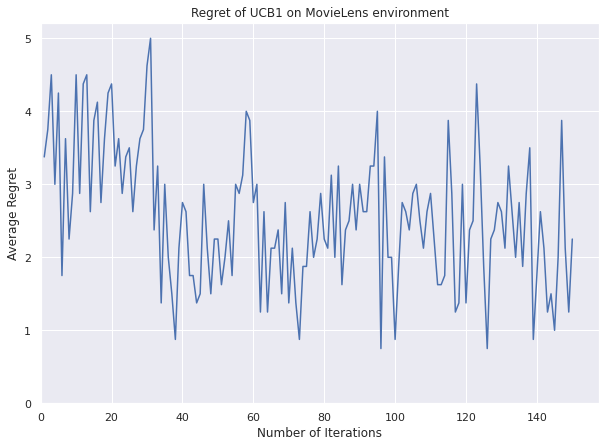

In [15]:
plot_regret(df_trajectory.groupby('trial').mean()['regret'], params)

Let's see the cumulative reward of the actions during the experiment.

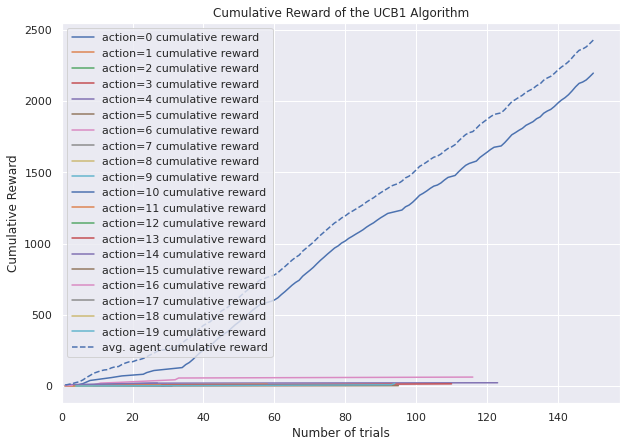

In [16]:
plot_cumsum(df_trajectory, params, show_actions=True)

#### Multiple runs

Because our environment selects users randomly, each run can produce different results. Let's what are the average results through multiple runs.

In [17]:
def experiment(
    epochs: int = 1, trials: int = 10, alpha: float = 1.0, batch_size: int = 1):
  trajectories = []
  
  environment = MovielensEnvironment(
      './ml-100k/u.data', 
      rank_k=RANK_K, 
      batch_size=batch_size, 
      num_movies=NUM_ACTIONS)
  params = {
      'best_action': environment.best_action
  }
  
  for epoch in trange(epochs):
    step = environment.reset()
    agent = Usb1Agent(
        environment.n_actions, 
        alpha, 
        batch_size=environment.batch_size)
    
    df = run(environment, agent, trials=trials)
    df['epoch'] = epoch + 1

    trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params

Compared to a single run, we have one extra parameter. `epochs` controls the number of independent runs of the training loop.

In [18]:
batch_size =   256# @param {type:"integer"}
epochs = 25 # @param {type: "integer"}
num_iterations =   150# @param {type:"integer"}
alpha =   2.0 # @param {type:"number"}

df_trajectory, params = experiment(
    epochs=epochs, 
    trials=num_iterations, 
    alpha=alpha,
    batch_size=batch_size)

Now let's see the result. After running the last code snippet, the resulting plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [19]:
params = {
    'algorithm': 'UCB1'
}

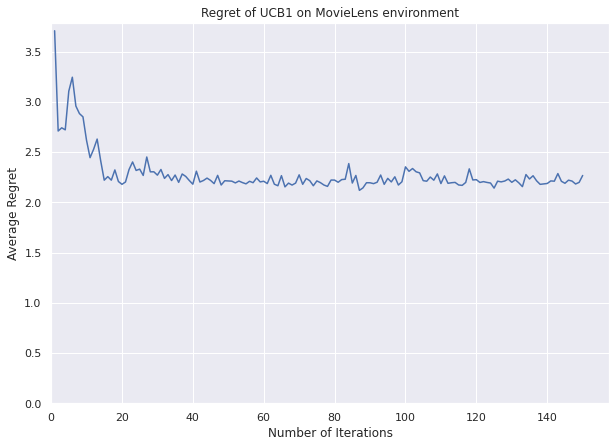

In [20]:
plot_regret(df_trajectory.groupby('trial').mean()['regret'], params)

Let's see the cumulative reward of the actions during the experiment.

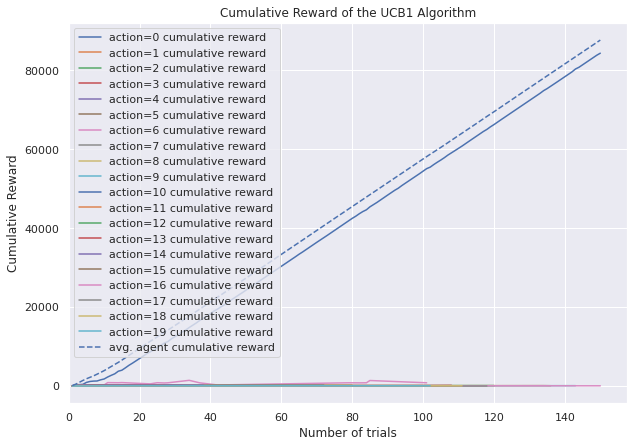

In [21]:
plot_cumsum(df_trajectory, params, show_actions=True)

Let's see the selection's rate of the actions during the experiment.

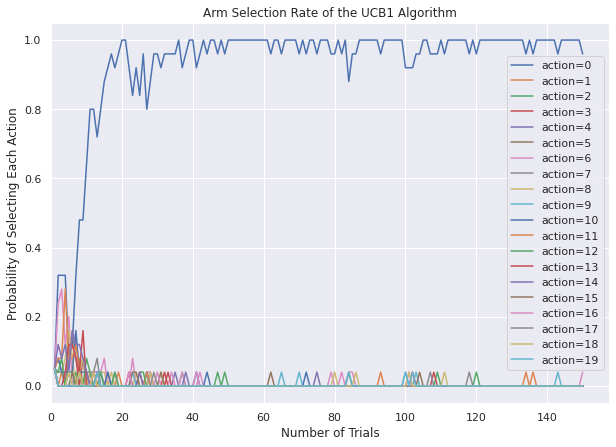

In [22]:
plot_actions(df_trajectory, params)